In [1]:
from functools import partial
import jax
import jax.numpy as np
from flax import linen as nn
from jax.nn.initializers import lecun_normal, normal
from jax.numpy.linalg import eigh, inv, matrix_power
from jax.scipy.signal import convolve

from ssm import *
rng = jax.random.PRNGKey(1)

In [2]:
def example_mass(k, b, m):
    A = np.array([[0, 1], [-k / m, -b / m]])
    B = np.array([[0], [1.0 / m]])
    C = np.array([[1.0, 0]])
    return A, B, C

In [3]:
@partial(np.vectorize, signature="()->()")
def example_force(t):
    x = np.sin(10 * t)
    return x * (x > 0.5)

In [4]:
def example_ssm():
    # SSM
    ssm = example_mass(k=40, b=5, m=1)

    # L samples of u(t).
    L = 100
    step = 1.0 / L
    ks = np.arange(L)
    u = example_force(ks * step)

    # Approximation of y(t).
    y = run_SSM(*ssm, u)

    # Plotting ---
    import matplotlib.pyplot as plt
    import seaborn
    from celluloid import Camera

    seaborn.set_context("paper")
    fig, (ax1, ax2, ax3) = plt.subplots(3)
    camera = Camera(fig)
    ax1.set_title("Force $u_k$")
    ax2.set_title("Position $y_k$")
    ax3.set_title("Object")
    ax1.set_xticks([], [])
    ax2.set_xticks([], [])

    # Animate plot over time
    for k in range(0, L, 2):
        ax1.plot(ks[:k], u[:k], color="red")
        ax2.plot(ks[:k], y[:k], color="blue")
        ax3.boxplot(
            [[y[k, 0] - 0.04, y[k, 0], y[k, 0] + 0.04]],
            showcaps=False,
            whis=False,
            vert=False,
            widths=10,
        )
        camera.snap()
    anim = camera.animate()
    anim.save("images/line.gif", dpi=150, writer="imagemagick")

MovieWriter imagemagick unavailable; using Pillow instead.


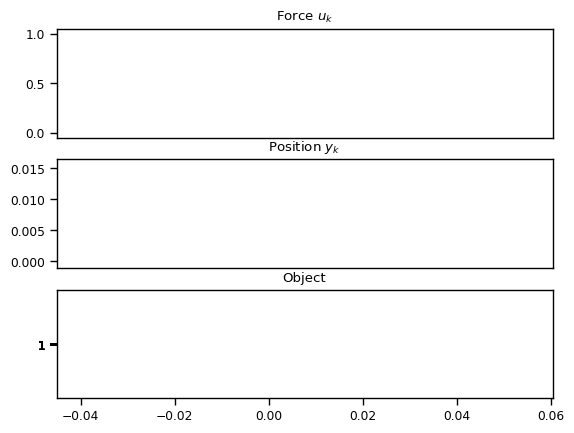

In [5]:
example_ssm()

In [6]:
def test_cnn_is_rnn(N=4, L=16, step=1.0 / 16):
    ssm = random_SSM(rng, N)
    u = jax.random.uniform(rng, (L,))
    jax.random.split(rng, 3)
    # RNN
    rec = run_SSM(*ssm, u)

    # CNN
    ssmb = discretize(*ssm, step=step)
    conv = causal_convolution(u, K_conv(*ssmb, L))

    # Check
    assert np.allclose(rec.ravel(), conv.ravel())

In [7]:
test_cnn_is_rnn()